# UniverSeg trên Dataset U Nang Buồng Trứng (Ovatus)

### Pipeline khám phá dữ liệu
- Load dataset
- Thống kê phân bố nhãn
- Visualize ví dụ điển hình cho từng loại nhãn

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install -r /content/drive/MyDrive/requirements_clean.txt


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-piobdeea/clip_330f8cc1158e4ea8a0246ba5eccb0e4d
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-piobdeea/clip_330f8cc1158e4ea8a0246ba5eccb0e4d
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

%matplotlib inline

### Định nghĩa đường dẫn dữ liệu
Thay đổi 2 đường dẫn bên dưới cho phù hợp với máy/Colab của bạn

In [16]:
# THAY ĐỔI THEO MÁY BẠN
DATA_ROOT = "/content/drive/MyDrive/US_map4"                  # Thư mục chứa các folder bệnh nhân
ANNOT_PATH = "/content/drive/MyDrive/mapping_normalized4.jsonl"  # File annotation

RESIZE_TO = (128, 128)

In [5]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw

# ================= CONFIG =================
DATA_ROOT = "/content/drive/MyDrive/US_map4"
ANNOT_PATH = "/content/drive/MyDrive/mapping_normalized4.jsonl"
RESIZE_TO = (128, 128)
# =========================================

LABEL2ID = {
    "nang_da_thuy": 0,
    "nang_don_thuy": 1,
    "nang_da_thuy_dac": 2,
    "nang_don_thuy_dac": 3,
    "u_bi": 4,
    "u_dac": 5
}
NUM_CLASSES = len(LABEL2ID)
LABEL_NAMES = list(LABEL2ID.keys())
# ---------- Utils ----------
def polygon_to_mask(points, image_size, resize_to):
    try:
        mask = Image.new('L', image_size, 0)
        if points is not None and len(points) >= 3:
            ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
        mask = mask.resize(resize_to, Image.NEAREST)
        return np.array(mask, dtype=np.float32)
    except Exception:
        return None


def process_image(image_path, resize_to):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(resize_to, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        return np.transpose(img, (2, 0, 1))
    except Exception:
        return None

# ---------- Dataset ----------
class OvatusDataset(Dataset):
    def __init__(self, annot_path=ANNOT_PATH, data_root=DATA_ROOT, resize_to=RESIZE_TO):
        self.samples = []

        print("=" * 70)
        print("Loading OvatusDataset (safe mode)...")
        print("=" * 70)

        with open(annot_path, "r", encoding="utf-8") as f:
            for line_idx, line in enumerate(f):
                try:
                    item = json.loads(line)
                except Exception:
                    continue  # bỏ qua dòng lỗi JSON

                patient = item.get("patient_name", None)
                if patient is None:
                    continue

                for img_info in item.get("images", []):
                    img_name = img_info.get("image_name", None)
                    if img_name is None:
                        continue

                    img_path = os.path.join(data_root, patient, img_name)
                    if not os.path.exists(img_path):
                        continue  # bỏ qua nếu không có ảnh

                    # ---- Load image ----
                    img = process_image(img_path, resize_to)
                    if img is None:
                        continue  # tránh treo cell

                    image_size = (
                        img_info.get("imageWidth"),
                        img_info.get("imageHeight")
                    )
                    if None in image_size:
                        continue

                    masks = np.zeros(
                        (NUM_CLASSES, resize_to[1], resize_to[0]),
                        dtype=np.float32
                    )

                    labels = img_info.get("labels", [])
                    polygons_list = img_info.get("points", [])

                    has_valid_mask = False

                    for lbl, poly_pts in zip(labels, polygons_list):
                        if lbl not in LABEL2ID:
                            continue
                        if not poly_pts or len(poly_pts) < 3:
                            continue

                        pts = [tuple(map(float, pt)) for pt in poly_pts]
                        mask = polygon_to_mask(pts, image_size, resize_to)
                        if mask is None:
                            continue

                        class_id = LABEL2ID[lbl]
                        masks[class_id] = np.maximum(masks[class_id], mask)
                        has_valid_mask = True

                    # ❗ QUAN TRỌNG: bỏ qua nếu không có mask hợp lệ
                    if not has_valid_mask:
                        continue

                    self.samples.append((img, masks, img_path))

        print(f"Loaded {len(self.samples)} valid samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, masks, img_path = self.samples[idx]
        return (
            torch.from_numpy(img).float(),
            torch.from_numpy(masks).float(),
            img_path
        )


### Load dataset

In [7]:
dataset = OvatusDataset()
print(f"\nTổng số ảnh có annotation: {len(dataset)}")

Loading OvatusDataset (safe mode)...
Loaded 583 valid samples.

Tổng số ảnh có annotation: 583


In [ ]:
!pip list

### Thống kê phân bố nhãn

In [8]:
label_counts = defaultdict(int)
label_indices = defaultdict(list)

for idx in range(len(dataset)):
    _, masks, _ = dataset[idx]
    for label_idx in range(NUM_CLASSES):
        if masks[label_idx].sum() > 10:  # Có vùng đáng kể
            label_counts[label_idx] += 1
            label_indices[label_idx].append(idx)

print("[INFO] Phân bố nhãn trong toàn bộ dataset:")
for label_idx in range(NUM_CLASSES):
    name = LABEL_NAMES[label_idx]
    count = label_counts[label_idx]
    pct = 100 * count / len(dataset)
    if count >= 100:
        status = "✅ COMMON"
    elif count >= 50:
        status = "✓ MEDIUM"
    elif count >= 20:
        status = "⚠️ RARE"
    else:
        status = "❌ VERY RARE"
    print(f"  [{label_idx}] {name:20s}: {count:3d} ảnh ({pct:5.1f}%) {status}")

[INFO] Phân bố nhãn trong toàn bộ dataset:
  [0] nang_da_thuy        : 151 ảnh ( 25.9%) ✅ COMMON
  [1] nang_don_thuy       : 108 ảnh ( 18.5%) ✅ COMMON
  [2] nang_da_thuy_dac    :  62 ảnh ( 10.6%) ✓ MEDIUM
  [3] nang_don_thuy_dac   :  31 ảnh (  5.3%) ⚠️ RARE
  [4] u_bi                : 116 ảnh ( 19.9%) ✅ COMMON
  [5] u_dac               : 137 ảnh ( 23.5%) ✅ COMMON


### Visualize ví dụ điển hình cho từng loại nhãn
Mỗi nhãn hiển thị tối đa 3 ảnh đại diện


=== HIỂN THỊ 1 ẢNH ĐẦU TIÊN MỖI NHÃN: ORIGINAL vs GT CONTOUR (ĐƯỜNG VIỀN) ===


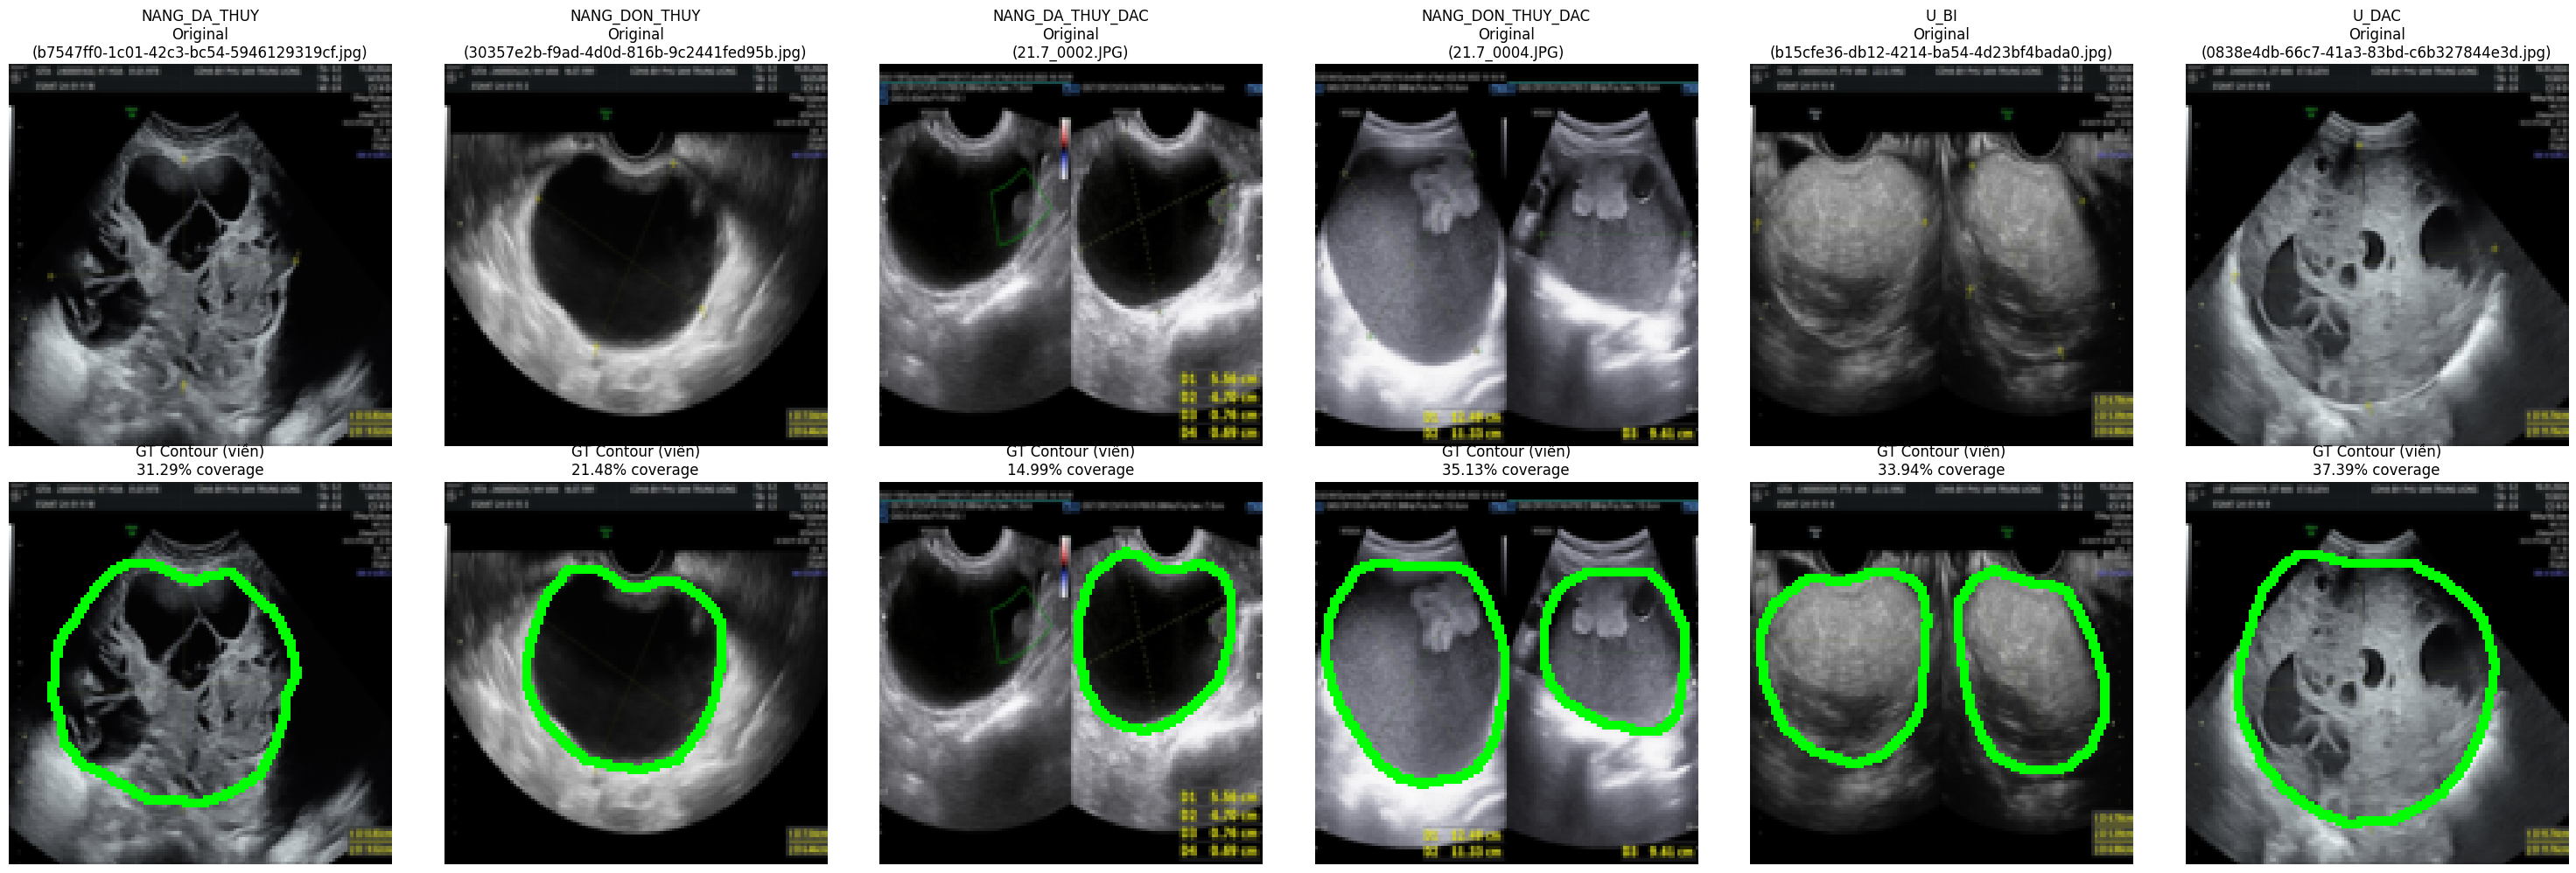

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import cv2  # OpenCV - thường đã có sẵn, không cần pip install trong Colab/Kaggle/Jupyter CV

def show_first_sample_with_gt_contour():
    print("\n=== HIỂN THỊ 1 ẢNH ĐẦU TIÊN MỖI NHÃN: ORIGINAL vs GT CONTOUR (ĐƯỜNG VIỀN) ===")

    # Lấy các nhãn có dữ liệu
    active_labels = [i for i in range(NUM_CLASSES) if len(label_indices[i]) > 0]

    if not active_labels:
        print("Không có nhãn nào có dữ liệu.")
        return

    num_cols = len(active_labels)
    fig, axes = plt.subplots(2, num_cols, figsize=(5 * num_cols, 10))

    # Xử lý trường hợp chỉ 1 nhãn
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    for col_idx, label_idx in enumerate(active_labels):
        name = LABEL_NAMES[label_idx]
        indices = label_indices[label_idx]
        first_idx = indices[0]  # Ảnh đầu tiên có nhãn này

        img, masks, path = dataset[first_idx]

        # Chuyển ảnh sang numpy RGB
        if isinstance(img, torch.Tensor):
            img_np = img.detach().cpu().numpy()
        else:
            img_np = img
        img_rgb = np.transpose(img_np, (1, 2, 0))
        img_rgb = np.clip(img_rgb, 0, 1)

        # Chuyển sang BGR uint8 để dùng OpenCV vẽ contour
        img_bgr = (img_rgb * 255).astype(np.uint8)[:, :, ::-1]  # RGB → BGR

        basename = os.path.basename(path)

        # Lấy mask nhị phân của nhãn hiện tại
        mask = masks[label_idx]
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy()
        mask_bin = (mask > 0).astype(np.uint8)  # 0 hoặc 1

        # Tính coverage
        coverage = 100.0 * np.sum(mask_bin) / mask_bin.size

        # Dùng OpenCV tìm contours (chỉ lấy contour ngoài cùng)
        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Tạo bản sao để vẽ contour
        img_with_contour = img_bgr.copy()
        cv2.drawContours(img_with_contour, contours, -1, (0, 255, 0), thickness=2)  # Màu xanh lá, dày 3px

        # Chuyển lại RGB để hiển thị với matplotlib
        img_with_contour_rgb = img_with_contour[:, :, ::-1]

        # === HÀNG TRÊN: Original Image ===
        axes[0, col_idx].imshow(img_rgb)
        axes[0, col_idx].set_title(f"{name.upper()}\nOriginal\n({basename})", fontsize=12)
        axes[0, col_idx].axis('off')

        # === HÀNG DƯỚI: Ảnh + GT Contour ===
        axes[1, col_idx].imshow(img_with_contour_rgb)
        axes[1, col_idx].set_title(f"GT Contour (viền)\n{coverage:.2f}% coverage", fontsize=12)
        axes[1, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

# ================== GỌI HÀM ==================
show_first_sample_with_gt_contour()


=== HIỂN THỊ NGẪU NHIÊN 1 ẢNH MỖI NHÃN: ORIGINAL vs GT CONTOUR (ĐƯỜNG VIỀN) ===


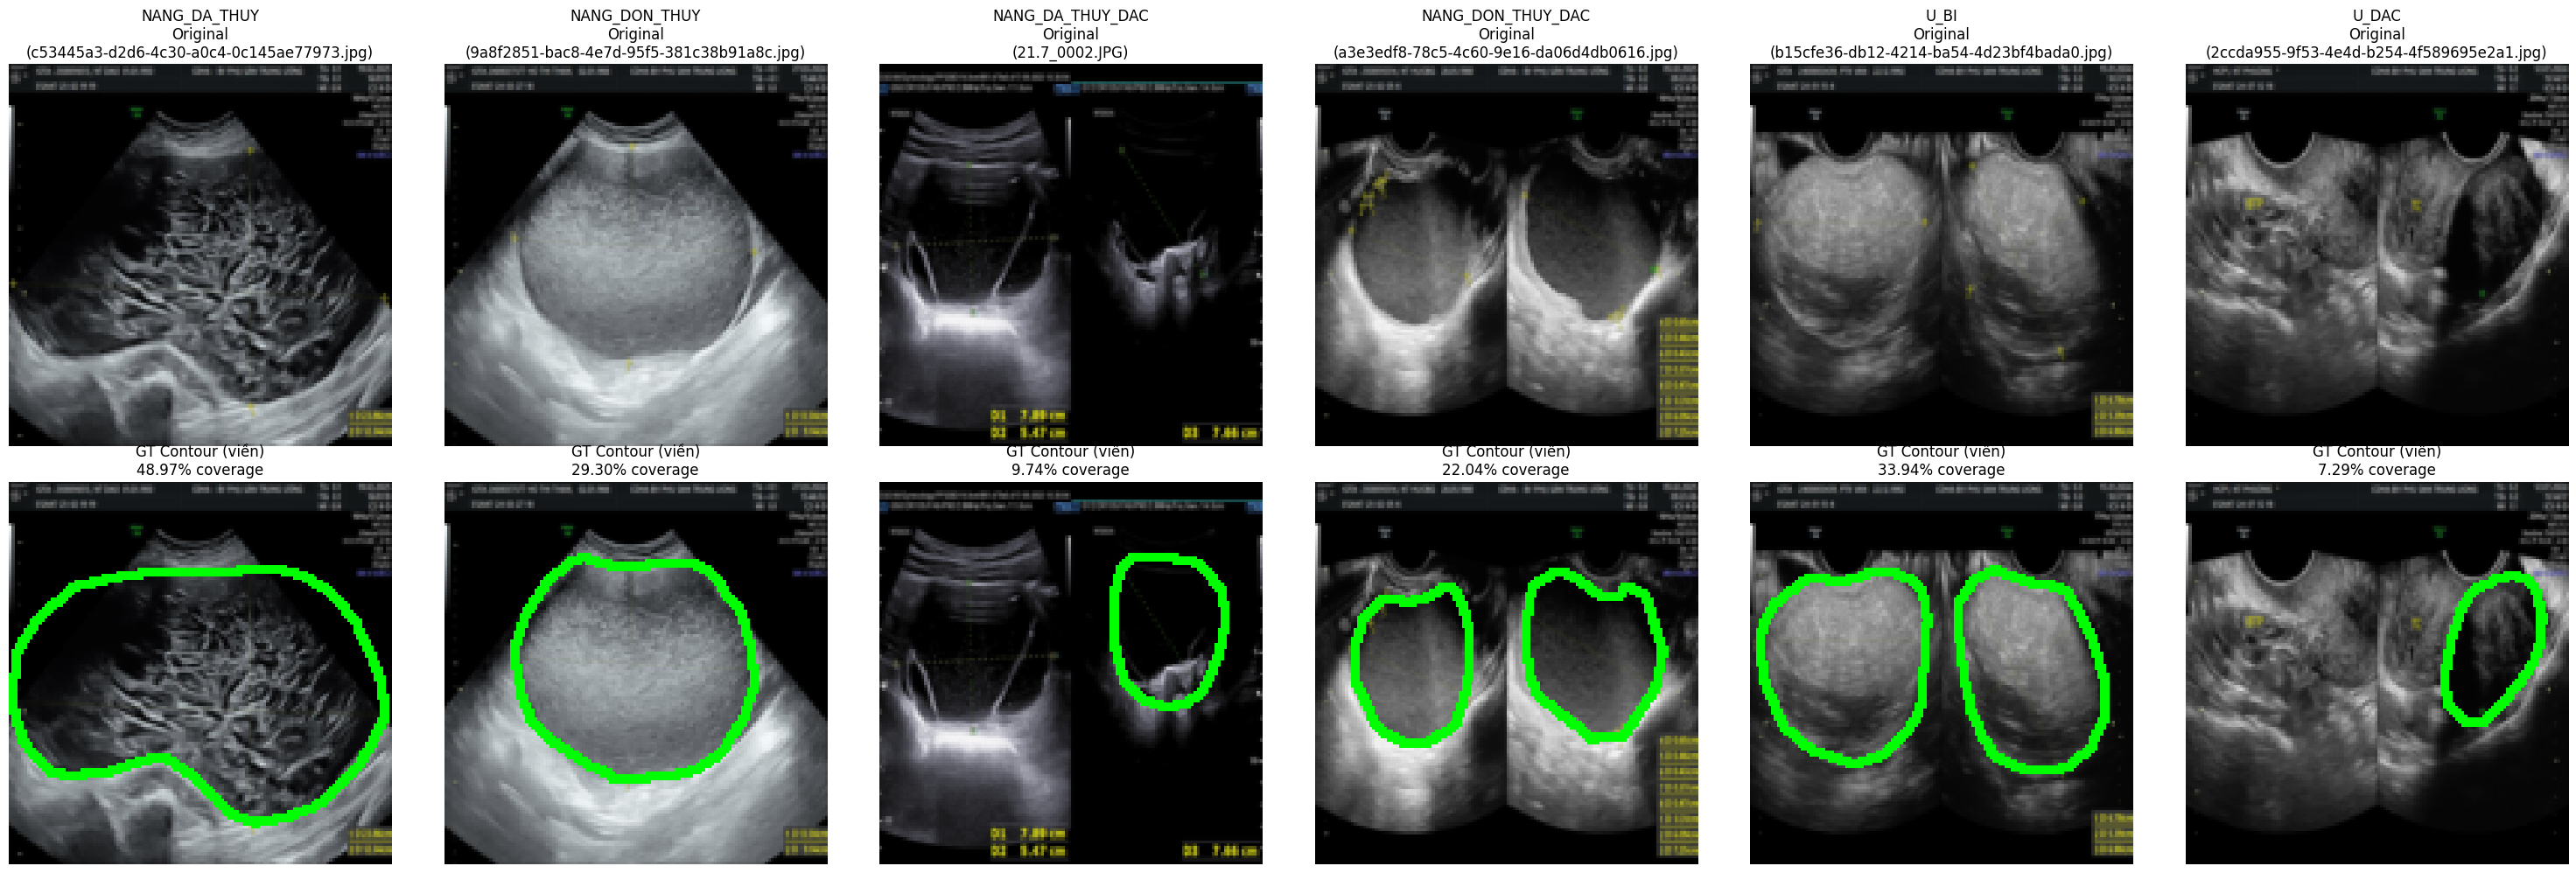

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import cv2

def show_random_sample_with_gt_contour():
    print("\n=== HIỂN THỊ NGẪU NHIÊN 1 ẢNH MỖI NHÃN: ORIGINAL vs GT CONTOUR (ĐƯỜNG VIỀN) ===")

    # Lấy các nhãn có dữ liệu
    active_labels = [i for i in range(NUM_CLASSES) if len(label_indices[i]) > 0]

    if not active_labels:
        print("Không có nhãn nào có dữ liệu.")
        return

    num_cols = len(active_labels)
    fig, axes = plt.subplots(2, num_cols, figsize=(5 * num_cols, 10))

    # Trường hợp chỉ có 1 nhãn
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    for col_idx, label_idx in enumerate(active_labels):
        name = LABEL_NAMES[label_idx]
        indices = label_indices[label_idx]

        # 🔥 CHỌN NGẪU NHIÊN 1 ẢNH
        rand_idx = np.random.choice(indices)

        img, masks, path = dataset[rand_idx]

        # Chuyển ảnh sang numpy RGB
        if isinstance(img, torch.Tensor):
            img_np = img.detach().cpu().numpy()
        else:
            img_np = img
        img_rgb = np.transpose(img_np, (1, 2, 0))
        img_rgb = np.clip(img_rgb, 0, 1)

        # Chuyển sang BGR uint8 cho OpenCV
        img_bgr = (img_rgb * 255).astype(np.uint8)[:, :, ::-1]

        basename = os.path.basename(path)

        # Lấy mask của nhãn hiện tại
        mask = masks[label_idx]
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy()
        mask_bin = (mask > 0).astype(np.uint8)

        # Coverage
        coverage = 100.0 * np.sum(mask_bin) / mask_bin.size

        # Tìm contour
        contours, _ = cv2.findContours(
            mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Vẽ contour
        img_with_contour = img_bgr.copy()
        cv2.drawContours(
            img_with_contour, contours, -1, (0, 255, 0), thickness=2
        )

        img_with_contour_rgb = img_with_contour[:, :, ::-1]

        # ===== HÀNG TRÊN: ORIGINAL =====
        axes[0, col_idx].imshow(img_rgb)
        axes[0, col_idx].set_title(
            f"{name.upper()}\nOriginal\n({basename})", fontsize=12
        )
        axes[0, col_idx].axis('off')

        # ===== HÀNG DƯỚI: GT CONTOUR =====
        axes[1, col_idx].imshow(img_with_contour_rgb)
        axes[1, col_idx].set_title(
            f"GT Contour (viền)\n{coverage:.2f}% coverage", fontsize=12
        )
        axes[1, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

# ================== GỌI HÀM ==================
show_random_sample_with_gt_contour()


In [11]:
# split_dataset.py
import numpy as np
import os
from torch.utils.data import Dataset, Subset
from typing import Tuple

def patient_level_split_80_20(
    dataset: Dataset,
    seed: int = 42
) -> Tuple[Subset, Subset]:
    """
    Chia theo subject (patient) với tỷ lệ 80-20:
    - 80% support pool → dùng để sample support set động
    - 20% test → báo cáo cuối cùng
    """
    patient_to_indices = {}
    print("\n" + "="*70)
    print("PATIENT-LEVEL SPLIT (80% Support - 20% Test)")
    print("="*70)

    for idx in range(len(dataset)):
        _, _, img_path = dataset[idx]
        patient = os.path.basename(os.path.dirname(img_path))
        patient_to_indices.setdefault(patient, []).append(idx)

    patients = list(patient_to_indices.keys())
    print(f"\nTổng số bệnh nhân: {len(patients)}")

    rng = np.random.default_rng(seed)
    rng.shuffle(patients)

    n = len(patients)
    n_support = int(0.8 * n)
    print(f"Phân chia: {n_support} support ({n_support/n*100:.1f}%) | {n - n_support} test ({(n-n_support)/n*100:.1f}%)")

    support_patients = patients[:n_support]
    test_patients = patients[n_support:]

    def get_idxs(p_list):
        return [i for p in p_list for i in patient_to_indices[p]]

    support_idxs = get_idxs(support_patients)
    test_idxs = get_idxs(test_patients)

    print(f"\n✅ Kết quả split:")
    print(f"   Support pool: {len(support_patients)} patients → {len(support_idxs)} images")
    print(f"   Test set    : {len(test_patients)} patients → {len(test_idxs)} images")
    print("="*70 + "\n")

    return Subset(dataset, support_idxs), Subset(dataset, test_idxs)

# ================== CHẠY SPLIT ==================
support_pool, test_set = patient_level_split_80_20(dataset, seed=42)


PATIENT-LEVEL SPLIT (80% Support - 20% Test)

Tổng số bệnh nhân: 293
Phân chia: 234 support (79.9%) | 59 test (20.1%)

✅ Kết quả split:
   Support pool: 234 patients → 458 images
   Test set    : 59 patients → 125 images



### Tiếp theo
Sau khi xem dữ liệu, bạn có thể tiếp tục với:
- Split patient-level (60/20/20)
- Inference với UniverSeg + adaptive stratified sampling (file infer.py đã có)

In [ ]:
# Cell: Phân bố nhãn trong Support Pool (phần quan trọng nhất cho few-shot)

from collections import defaultdict
import numpy as np

print("=== PHÂN BỐ NHÃN TRONG SUPPORT POOL () ===\n")

label_counts_support = defaultdict(int)
label_indices_support = defaultdict(list)

for idx in range(len(support_pool)):
    _, masks, _ = support_pool[idx]  # masks: torch.Tensor [6, 128, 128]
    for label_idx in range(NUM_CLASSES):
        if masks[label_idx].sum() > 10:  # Có vùng đáng kể
            label_counts_support[label_idx] += 1
            label_indices_support[label_idx].append(idx)

print(f"{'ID':<3} {'Tên nhãn':<25} {'Số ảnh':<6} {'Tỷ lệ':<8} Trạng thái")
print("-" * 60)

total_images = len(support_pool)
for label_idx in sorted(label_counts_support.keys()):
    name = LABEL_NAMES[label_idx]
    count = label_counts_support[label_idx]
    pct = 100 * count / total_images

    if count >= 100:
        status = "✅ COMMON"
    elif count >= 60:
        status = "✓ MEDIUM"
    elif count >= 30:
        status = "⚠️ RARE"
    else:
        status = "❌ VERY RARE"

    print(f"{label_idx:<3} {name:<25} {count:<6} {pct:5.1f}%   {status}")

# In thêm cảnh báo nếu có class quá hiếm
very_rare = [LABEL_NAMES[i] for i, c in label_counts_support.items() if c < 20]
if very_rare:
    print(f"\n⚠️  CẢNH BÁO: Các class VERY RARE trong support pool: {', '.join(very_rare)}")
    print("   → Cần áp dụng adaptive stratified sampling (như trong infer.py của bạn) để đảm bảo performance!")
else:
    print("\n✅ Tất cả các class đều có đủ ví dụ trong support pool.")

=== PHÂN BỐ NHÃN TRONG SUPPORT POOL (336 ảnh) ===

ID  Tên nhãn                  Số ảnh Tỷ lệ    Trạng thái
------------------------------------------------------------
0   nang_da_thuy              127     27.7%   ✅ COMMON
1   nang_don_thuy             83      18.1%   ✓ MEDIUM
2   nang_da_thuy_dac          49      10.7%   ⚠️ RARE
3   nang_don_thuy_dac         18       3.9%   ❌ VERY RARE
4   u_bi                      92      20.1%   ✓ MEDIUM
5   u_dac                     104     22.7%   ✅ COMMON

⚠️  CẢNH BÁO: Các class VERY RARE trong support pool: nang_don_thuy_dac
   → Cần áp dụng adaptive stratified sampling (như trong infer.py của bạn) để đảm bảo performance!


Đang tìm ảnh test có Dice cao nhất cho từng class (trong 100 ảnh đầu)...
  → nang_da_thuy              : Best Dice = 0.961 | Ảnh: 9ec4c59d-5e34-47a0-8d6e-bbcda6d633f1.jpg
  → nang_don_thuy             : Best Dice = 0.966 | Ảnh: f653a06a-6fc7-4dbb-b49c-cf6eb2fbefa6.jpg
  → nang_da_thuy_dac          : Best Dice = 0.928 | Ảnh: f96cd989-a7a6-455e-9dc1-870ce4719c6b.jpg
  → nang_don_thuy_dac         : Best Dice = 0.872 | Ảnh: 9187a9ca-7091-4bb2-bf34-7fc4482e1774.jpg
  → u_bi                      : Best Dice = 0.934 | Ảnh: b15cfe36-db12-4214-ba54-4d23bf4bada0.jpg
  → u_dac                     : Best Dice = 0.925 | Ảnh: 52cea44b-aade-4eb3-8dd9-614f629f3167.jpg

Đang chạy inference đầy đủ cho bảng 7x6 (mỗi class dùng ảnh riêng)...
Pre-computing predictions cho từng class trên ảnh tốt nhất...
  → nang_da_thuy              : Best Dice = 0.957 | Ảnh: 7963f797-08e8-427f-9f7d-8f71a6fe91c3.jpg (idx=62)
  → nang_don_thuy             : Best Dice = 0.965 | Ảnh: f653a06a-6fc7-4dbb-b49c-cf6eb2fbefa6.jpg (

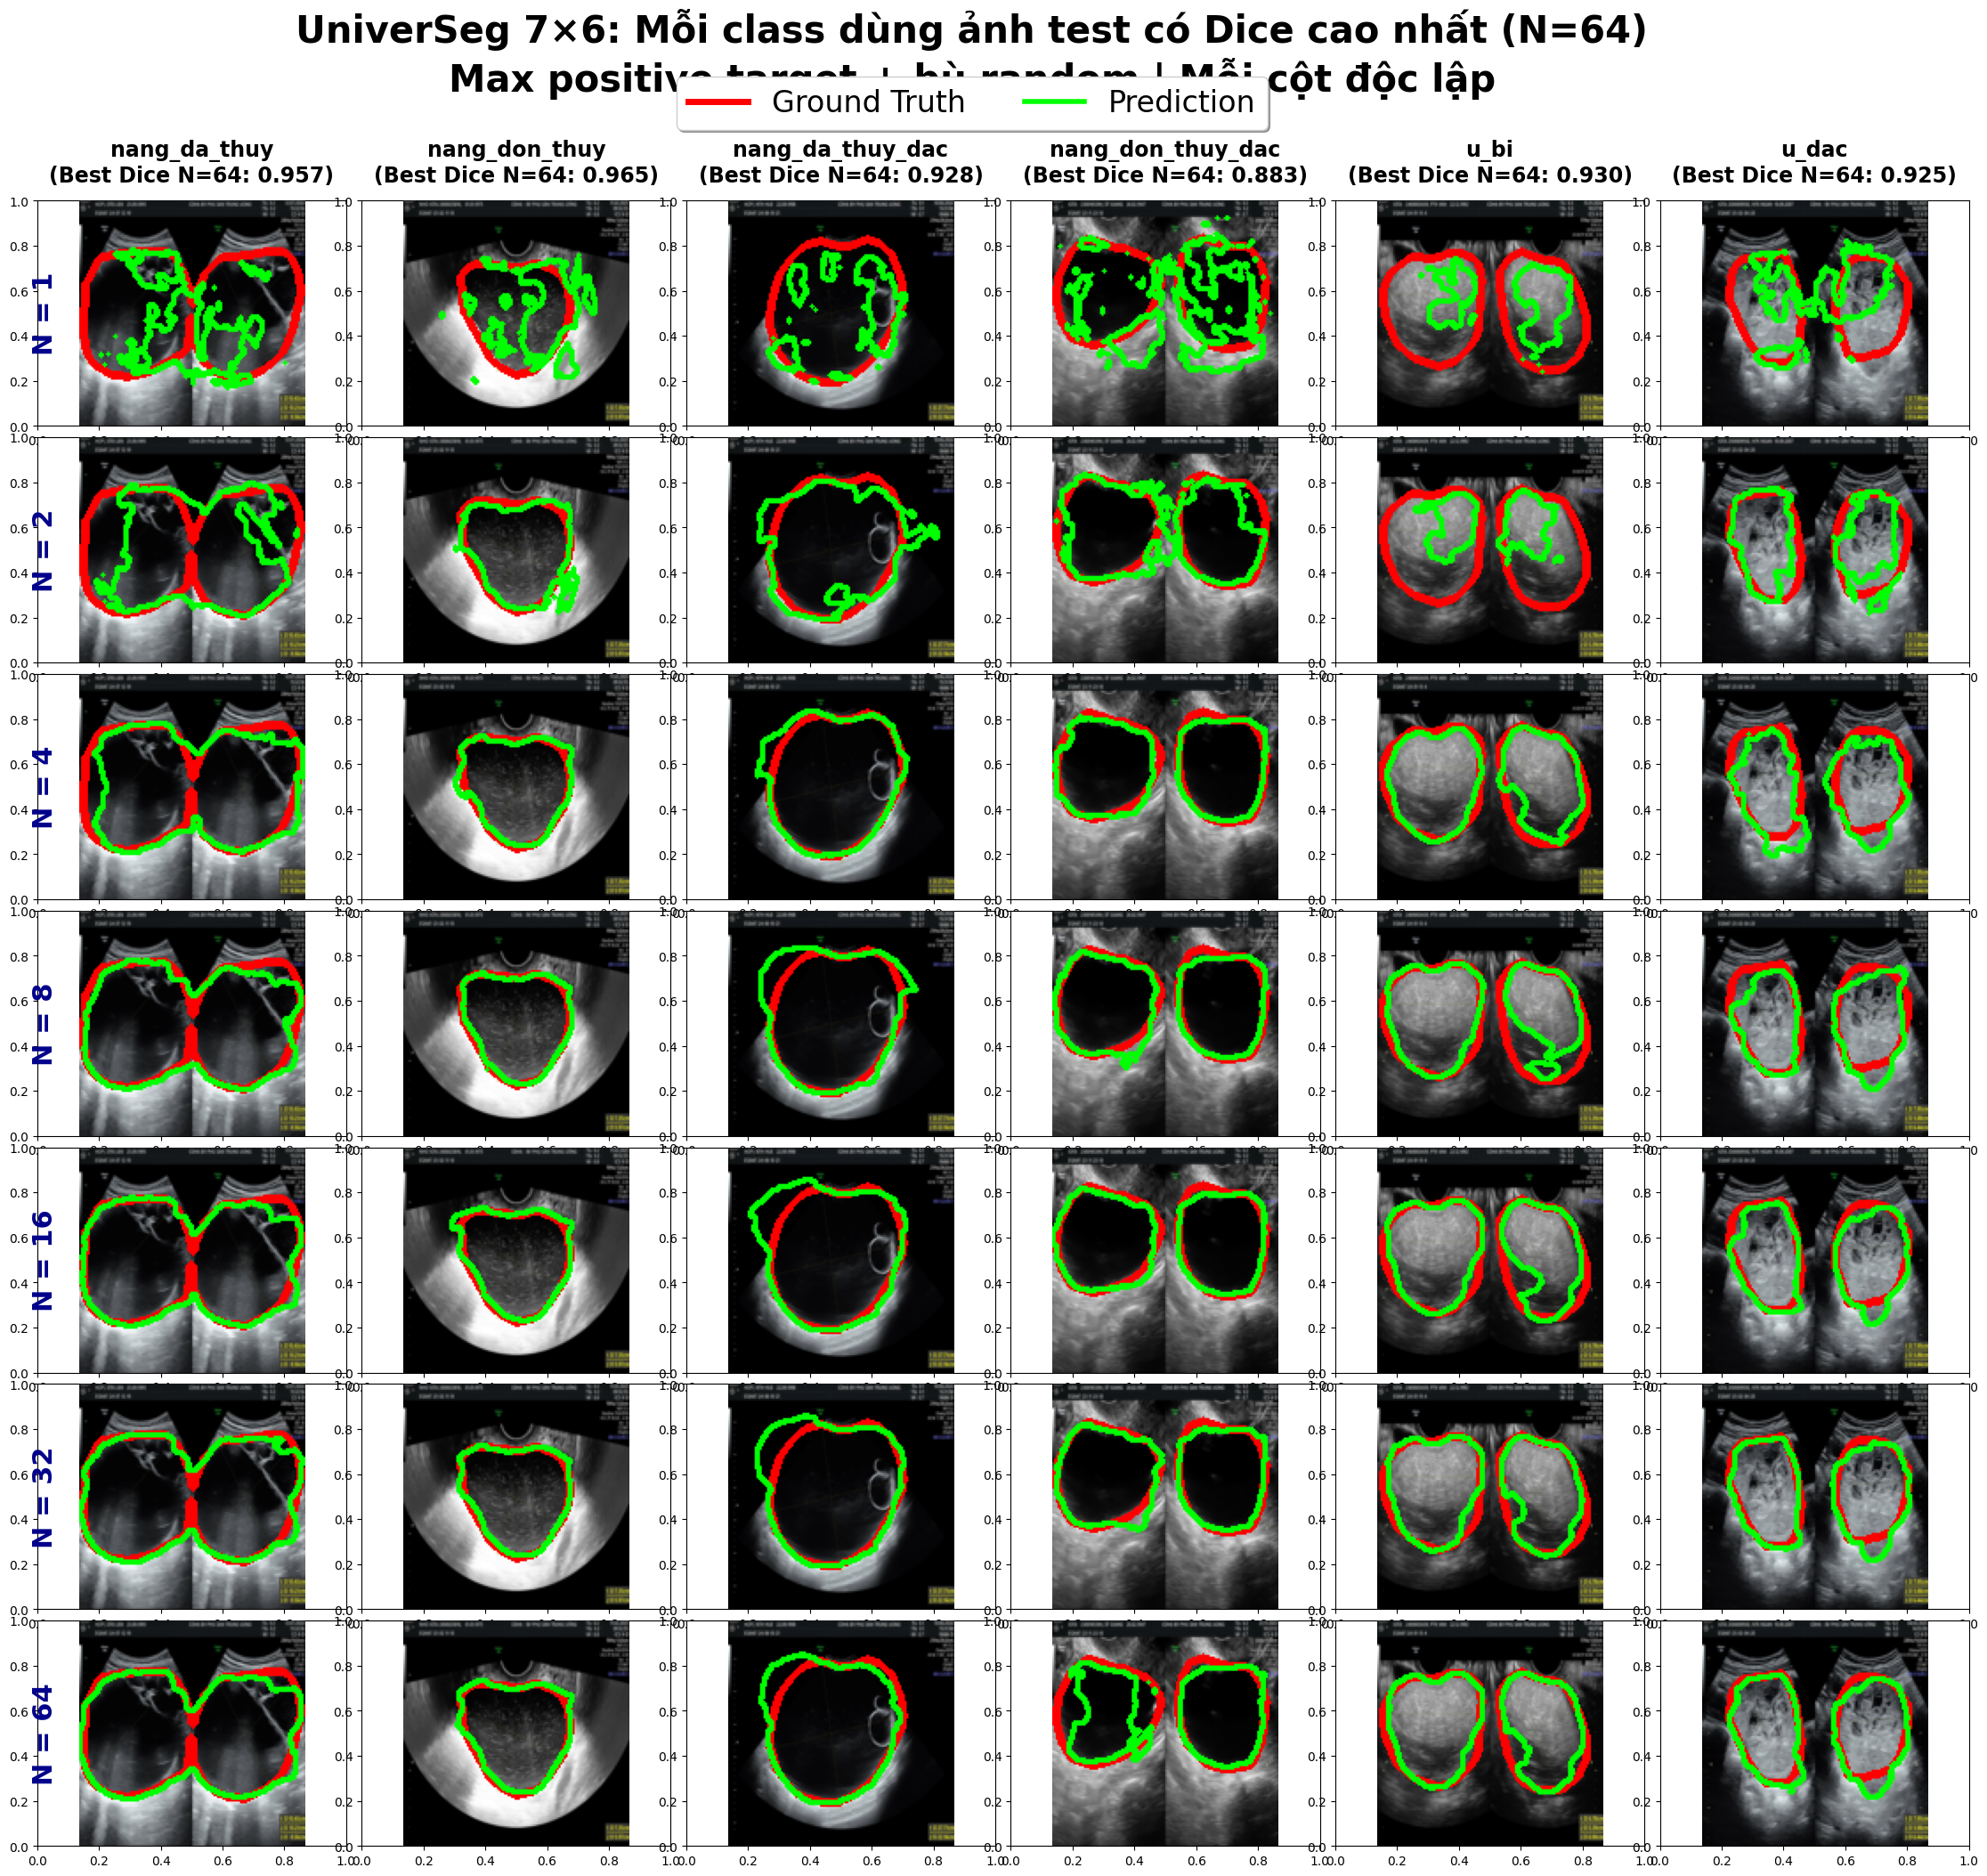

In [ ]:
import clip

ModuleNotFoundError: No module named 'clip'

In [13]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ul2ybj05
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ul2ybj05
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [14]:
!pip install git+https://github.com/JJGO/UniverSeg.git

  Cloning https://github.com/JJGO/UniverSeg.git to /tmp/pip-req-build-03lestyo
  Running command git clone --filter=blob:none --quiet https://github.com/JJGO/UniverSeg.git /tmp/pip-req-build-03lestyo
  Resolved https://github.com/JJGO/UniverSeg.git to commit 833a0c34c65e38d675e21bd48ddec6797cc03259
  Preparing metadata (setup.py) ... done


In [ ]:
import clip

In [15]:
# Grok Cell: Bảng 7x6 - Mỗi class dùng 1 ảnh test riêng có Dice cao nhất cho class đó
# CLIP-guided support selection: Top-N overall similar images (theo tinh thần MatchSeg)

import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from universeg import universeg
from matplotlib.lines import Line2D
from PIL import Image
import clip  # pip install git+https://github.com/openai/CLIP.git

# ================== CONFIG ==================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_LIST = [1, 2, 4, 8, 16, 32, 64]
ALL_LABELS = range(6)
K_ENSEMBLE = 1  # CLIP deterministic → không cần ensemble nhiều
THRESHOLD = 0.45
N_EVAL = 64                    # Dùng N lớn để chọn ảnh tốt nhất cho mỗi class
SEARCH_NUM = min(100, len(test_set))  # Tìm trong nhiều ảnh test

# Load model
model = universeg(pretrained=True).to(DEVICE)
model.eval()

# Load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/16", device=DEVICE)

# ================== HELPER ==================
def dice_score(pred, gt, threshold=THRESHOLD, smooth=1e-6):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * gt).sum()
    union = pred_bin.sum() + gt.sum()
    return (2. * intersection + smooth) / (union + smooth)

def get_clip_emb(img_tensor):
    # img_tensor: [3, H, W], giá trị 0-1
    img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_np)
    image_input = clip_preprocess(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = clip_model.encode_image(image_input)
    return emb / emb.norm(p=2, dim=-1, keepdim=True)

# Precompute CLIP embeddings cho toàn bộ support_pool
print("Precomputing CLIP embeddings cho support_pool...")
support_embs = torch.cat([get_clip_emb(s[0]) for s in support_pool], dim=0)

# ================== NEW: CLIP-guided selection theo tinh thần MatchSeg ==================
# def clip_support_selection_class(query_img, target_label, n_total):
#     """
#     Chọn top-n_total support images có similarity cao nhất với query (overall),
#     theo tinh thần MatchSeg paper: top-K most similar supports bất kể class.
#     Mask vẫn lấy channel tương ứng với target_label.
#     """
#     query_emb = get_clip_emb(query_img)

#     # Tính similarity với TOÀN BỘ support images
#     sims = (query_emb @ support_embs.T)[0].cpu().numpy()  # [num_supports]

#     target_pool = label_indices_support[target_label]

#     if len(target_pool) == 0:
#         # Không có positive nào cho class này → chọn random
#         final_idxs = np.random.choice(
#             range(len(support_pool)),
#             size=min(n_total, len(support_pool)),
#             replace=False
#         ).tolist()
#     else:
#         # Chọn top-n_total similar nhất trong toàn bộ pool
#         sorted_all_idx = np.argsort(-sims)  # descending similarity
#         final_idxs = sorted_all_idx[:n_total].tolist()

#     # Extract images và masks (chỉ lấy channel của target_label)
#     imgs = [support_pool[i][0].mean(dim=0, keepdim=True) for i in final_idxs]
#     masks = [support_pool[i][1][target_label].unsqueeze(0) for i in final_idxs]

#     support_imgs = torch.stack(imgs).unsqueeze(0).to(DEVICE)      # [1, N, 1, H, W]
#     support_masks = torch.stack(masks).unsqueeze(0).to(DEVICE)    # [1, N, 1, H, W]

#     return support_imgs, support_masks

def clip_support_selection_class(query_img, target_label, n_total):
    """
    Class-aware CLIP-guided support selection (UniVerSeg-safe)

    - N = n_total là N danh nghĩa (chung)
    - Effective support K = min(N, số mẫu của class)
    - CLIP chỉ dùng để xếp hạng trong pool của class
    """

    # CLIP embedding của query
    query_emb = get_clip_emb(query_img)  # [1, D]

    # Pool support của class target
    target_pool = label_indices_support[target_label]
    num_cls = len(target_pool)

    # Nếu class không có sample → fallback random (hiếm)
    if num_cls == 0:
        final_idxs = np.random.choice(
            range(len(support_pool)),
            size=min(n_total, len(support_pool)),
            replace=False
        ).tolist()
    else:
        # Effective support size
        K = min(n_total, num_cls)

        # Lấy embedding CLIP của class target
        cls_embs = support_embs[target_pool]      # [num_cls, D]

        # Similarity query – support (trong class)
        sims = (query_emb @ cls_embs.T)[0].cpu().numpy()  # [num_cls]

        # Top-K similar nhất
        topk_idx = np.argsort(-sims)[:K]
        final_idxs = [target_pool[i] for i in topk_idx]

    # Lấy ảnh & mask
    imgs = [support_pool[i][0].mean(dim=0, keepdim=True) for i in final_idxs]
    masks = [support_pool[i][1][target_label].unsqueeze(0) for i in final_idxs]

    support_imgs = torch.stack(imgs).unsqueeze(0).to(DEVICE)    # [1, K, 1, H, W]
    support_masks = torch.stack(masks).unsqueeze(0).to(DEVICE)  # [1, K, 1, H, W]

    return support_imgs, support_masks


# ================== TÌM ẢNH TỐT NHẤT CHO TỪNG CLASS ==================
print(f"Đang tìm ảnh test có Dice cao nhất cho từng class (trong {SEARCH_NUM} ảnh đầu)...")

best_image_per_class = {}  # label_idx -> (best_dice, idx, filename)

for label_idx in ALL_LABELS:
    best_dice = -1
    best_idx = None
    best_name = None

    for idx in range(SEARCH_NUM):
        query_img, query_gt, img_path = test_set[idx]
        if query_gt[label_idx].sum() <= 10:  # Bỏ qua nếu ít pixel positive
            continue

        query_img_dev = query_img.to(DEVICE)
        query_gray = query_img_dev.mean(dim=0, keepdim=True).unsqueeze(0)

        preds = []
        for _ in range(K_ENSEMBLE):
            sup_imgs, sup_masks = clip_support_selection_class(query_img, label_idx, N_EVAL)
            with torch.no_grad():
                prob = torch.sigmoid(model(query_gray, sup_imgs, sup_masks)[0, 0])
                preds.append(prob)
        avg_pred = torch.mean(torch.stack(preds), dim=0)
        d = dice_score(avg_pred, query_gt[label_idx].to(DEVICE)).item()

        if d > best_dice:
            best_dice = d
            best_idx = idx
            best_name = os.path.basename(img_path)

    if best_idx is not None:
        best_image_per_class[label_idx] = (best_dice, best_idx, best_name)
        print(f"  → {LABEL_NAMES[label_idx]:25} : Best Dice = {best_dice:.3f} | Ảnh: {best_name} (idx={best_idx})")

# ================== INFERENCE VÀ VẼ BẢNG 7x6 ==================
print("\nĐang chạy inference đầy đủ cho bảng 7x6 (mỗi class dùng ảnh riêng)...")

predictions = {}  # (label_idx, N) -> pred_numpy
rgb_cache = {}    # label_idx -> rgb_uint8
gt_cache = {}     # label_idx -> gt_channel_cpu

for label_idx, (_, best_idx, _) in best_image_per_class.items():
    query_img, query_gt, _ = test_set[best_idx]
    query_img_dev = query_img.to(DEVICE)
    query_gray = query_img_dev.mean(dim=0, keepdim=True).unsqueeze(0)

    # Cache RGB và GT
    rgb_float = query_img_dev.permute(1, 2, 0).cpu().numpy()
    rgb_float = (rgb_float - rgb_float.min()) / (rgb_float.max() - rgb_float.min() + 1e-8)
    rgb_cache[label_idx] = (rgb_float * 255).astype(np.uint8)
    gt_cache[label_idx] = query_gt[label_idx].cpu()

    # Inference cho từng N
    for N in N_LIST:
        preds = []
        for _ in range(K_ENSEMBLE):
            sup_imgs, sup_masks = clip_support_selection_class(query_img, label_idx, N)
            with torch.no_grad():
                prob = torch.sigmoid(model(query_gray, sup_imgs, sup_masks)[0, 0]).cpu().numpy()
                preds.append(prob)
        predictions[(label_idx, N)] = np.mean(preds, axis=0)

# ================== VẼ BẢNG 7x6 ==================
fig = plt.figure(figsize=(28, 24))
gs = fig.add_gridspec(7, 6, hspace=0.05, wspace=0.05)

for row, N in enumerate(N_LIST):
    for col, label_idx in enumerate(ALL_LABELS):
        ax = fig.add_subplot(gs[row, col])

        if label_idx not in rgb_cache:
            ax.text(0.5, 0.5, 'No image', ha='center', va='center', fontsize=16, color='gray', transform=ax.transAxes)
            ax.axis('off')
            continue

        vis = rgb_cache[label_idx].copy()

        # Ground Truth: đỏ, dày
        gt_mask = (gt_cache[label_idx].numpy() > 0.5).astype(np.uint8) * 255
        contours_gt, _ = cv2.findContours(gt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis, contours_gt, -1, (255, 0, 0), thickness=4)

        # Prediction: xanh lá, mỏng
        pred = predictions[(label_idx, N)]
        pred_bin = (pred > THRESHOLD).astype(np.uint8) * 255
        contours_pred, _ = cv2.findContours(pred_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis, contours_pred, -1, (0, 255, 0), thickness=2)

        ax.imshow(vis)
        ax.axis('off')

        if row == 0:
            dice_N64 = best_image_per_class[label_idx][0]
            ax.set_title(f"{LABEL_NAMES[label_idx]}\n(Best Dice N=64: {dice_N64:.3f})",
                         fontsize=17, fontweight='bold', pad=15)
        if col == 0:
            ax.text(-0.15, 0.5, f"N = {N}", transform=ax.transAxes, fontsize=22,
                    rotation=90, va='center', ha='center', fontweight='bold', color='darkblue')

# Legend & Title
legend_elements = [
    Line2D([0], [0], color='red', lw=5, label='Ground Truth'),
    Line2D([0], [0], color='lime', lw=4, label='Prediction')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.945),
           ncol=2, fontsize=24, frameon=True, fancybox=True, shadow=True)

fig.suptitle("UniverSeg 7×6: Mỗi class dùng ảnh test có Dice cao nhất (N=64)\n"
             "CLIP-guided support selection | Top-N overall most similar supports (MatchSeg style) | Mỗi cột độc lập",
             fontsize=30, y=0.97, fontweight='bold')

save_path = "UniverSeg_7x6_per_class_best_image_CLIP_MatchSeg_style.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nHOÀN TẤT! Bảng đã lưu tại: {save_path}")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Đang tính PR curve trên TOÀN BỘ test set (125 ảnh)...
Tổng số pixel positive: 429923
Tổng số pixel: 2162688

Average Precision trên TOÀN test set: 0.8531
Đã lưu PR curve toàn test set tại: PR_curve_full_test_set_N32_K8.png


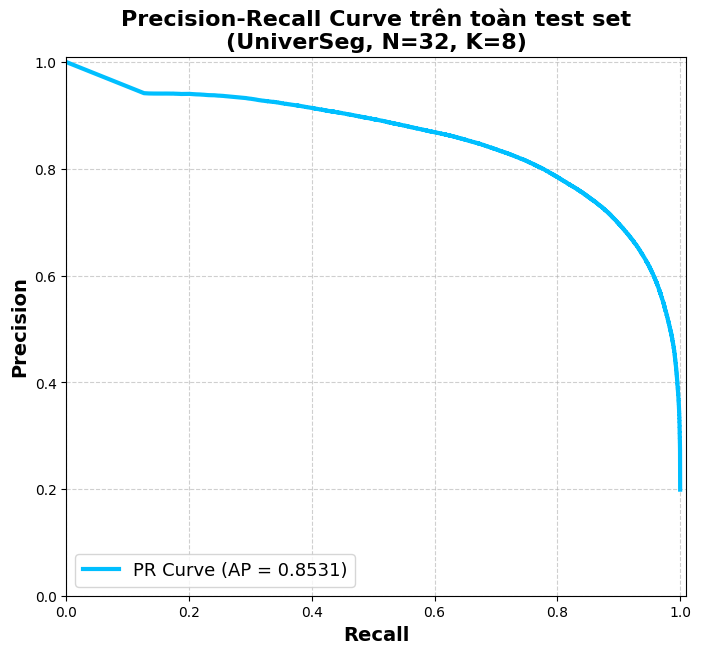

Đã lưu PR curve tại: PR_curve_UniverSeg_N32_K8.png


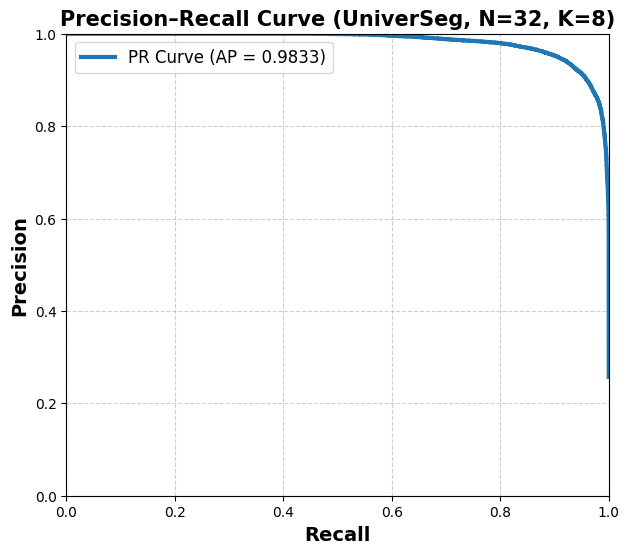

In [18]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

# ================== METRICS ==================
def compute_metrics(pred: np.ndarray, gt: np.ndarray, threshold: float = 0.45, smooth: float = 1e-6):
    pred_bin = (pred > threshold).astype(np.float32)
    gt_bin = (gt > 0.5).astype(np.float32)

    intersection = (pred_bin * gt_bin).sum()
    pred_sum = pred_bin.sum()
    gt_sum = gt_bin.sum()

    dice = (2. * intersection + smooth) / (pred_sum + gt_sum + smooth)
    iou = (intersection + smooth) / (pred_sum + gt_sum - intersection + smooth)
    precision = intersection / (pred_sum + smooth) if pred_sum > 0 else 1.0
    recall = intersection / (gt_sum + smooth) if gt_sum > 0 else 1.0

    return {
        'Dice': dice,
        'IoU': iou,
        'Precision': precision,
        'Recall': recall
    }

# ================== CONFIG ==================
THRESHOLD = 0.45
MIN_PIXELS = 10

print("\n" + "="*100)
print("ĐÁNH GIÁ UNIVERIVERSEG + CLASS-AWARE CLIP SUPPORT SELECTION")
print(f"Số ảnh test: {len(test_set)} | Threshold: {THRESHOLD}")
print("="*100)

# ================== STORAGE ==================
all_metrics = {}  # (label_idx, N) -> list of metric dicts

# ================== EVALUATION LOOP ==================
for query_idx in tqdm(range(len(test_set)), desc="Evaluating"):
    query_img, query_gt, img_path = test_set[query_idx]

    # UniVerSeg dùng ảnh gray
    query_gray = query_img.to(DEVICE).mean(dim=0, keepdim=True).unsqueeze(0)  # [1,1,H,W]

    # Bỏ ảnh không có lesion nào đáng kể
    if not any(query_gt[l].sum() > MIN_PIXELS for l in range(NUM_CLASSES)):
        continue

    for N in N_LIST:
        for label_idx in range(NUM_CLASSES):
            if query_gt[label_idx].sum() <= MIN_PIXELS:
                continue

            # ===== CLIP class-aware support selection =====
            sup_imgs, sup_masks = clip_support_selection_class(
                query_img=query_img,          # ⚠️ RGB cho CLIP
                target_label=label_idx,
                n_total=N
            )

            with torch.no_grad():
                prob = torch.sigmoid(
                    model(query_gray, sup_imgs, sup_masks)[0, 0]
                ).cpu().numpy()

            # Metrics
            mets = compute_metrics(
                prob,
                query_gt[label_idx].numpy(),
                threshold=THRESHOLD
            )

            key = (label_idx, N)
            all_metrics.setdefault(key, []).append(mets)

# ================== SUMMARY ==================
print("\nTổng hợp kết quả trung bình theo class và N...")

metrics_summary = []

for label_idx in ALL_LABELS:
    row = {'Class': LABEL_NAMES[label_idx]}

    for N in N_LIST:
        key = (label_idx, N)
        if key not in all_metrics:
            row.update({
                f'Dice_N{N}': '-',
                f'IoU_N{N}': '-',
                f'Prec_N{N}': '-',
                f'Rec_N{N}': '-',
                f'#Samples_N{N}': 0
            })
            continue

        vals = all_metrics[key]
        row[f'Dice_N{N}'] = f"{np.mean([v['Dice'] for v in vals]):.3f}"
        row[f'IoU_N{N}']  = f"{np.mean([v['IoU'] for v in vals]):.3f}"
        row[f'Prec_N{N}'] = f"{np.mean([v['Precision'] for v in vals]):.3f}"
        row[f'Rec_N{N}']  = f"{np.mean([v['Recall'] for v in vals]):.3f}"
        row[f'#Samples_N{N}'] = len(vals)

    metrics_summary.append(row)

# ================== DATAFRAME ==================
columns = ['Class']
for N in N_LIST:
    columns += [f'Dice_N{N}', f'IoU_N{N}', f'Prec_N{N}', f'Rec_N{N}', f'#Samples_N{N}']

df_full = pd.DataFrame(metrics_summary)[columns]

# ================== SAVE ==================
df_full.to_csv("UniverSeg_CLIP_ClassAware_Eval.csv", index=False)
df_full.to_excel("UniverSeg_CLIP_ClassAware_Eval.xlsx", index=False)

print("\nĐÁNH GIÁ HOÀN TẤT – ĐÃ LƯU FILE CSV & XLSX")



ĐÁNH GIÁ UNIVERIVERSEG + CLASS-AWARE CLIP SUPPORT SELECTION
Số ảnh test: 125 | Threshold: 0.45


Evaluating: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]



Tổng hợp kết quả trung bình theo class và N...

ĐÁNH GIÁ HOÀN TẤT – ĐÃ LƯU FILE CSV & XLSX


In [19]:
import pandas as pd
import numpy as np

# ================== TẠO BẢNG MACRO AVERAGE 7x5 ==================
print("\n" + "="*80)
print("BẢNG KẾT QUẢ MACRO AVERAGE - UNIVERSEG TRÊN TOÀN BỘ TEST SET")
print("="*80)

# Lấy dòng Macro Avg từ df_full đã tính ở cell trước
macro_row = df_full[df_full['Class'] == 'Macro Avg'].iloc[0]

# Tạo dữ liệu cho bảng 7x5
macro_table_data = {
    'N (shots)': N_LIST,
    'Dice':      [],
    'IoU':       [],
    'Precision': [],
    'Recall':    []
}

for N in N_LIST:
    macro_table_data['Dice'].append(float(macro_row[f'Dice_N{N}']) if macro_row[f'Dice_N{N}'] != '-' else 0.0)
    macro_table_data['IoU'].append(float(macro_row[f'IoU_N{N}']) if macro_row[f'IoU_N{N}'] != '-' else 0.0)
    macro_table_data['Precision'].append(float(macro_row[f'Prec_N{N}']) if macro_row[f'Prec_N{N}'] != '-' else 0.0)
    macro_table_data['Recall'].append(float(macro_row[f'Rec_N{N}']) if macro_row[f'Rec_N{N}'] != '-' else 0.0)

# Tạo DataFrame 7x5
df_macro_7x5 = pd.DataFrame(macro_table_data)

# Làm tròn 3 chữ số thập phân
df_macro_7x5[['Dice', 'IoU', 'Precision', 'Recall']] = df_macro_7x5[['Dice', 'IoU', 'Precision', 'Recall']].round(3)

# Hiển thị bảng đẹp (căn giữa, gradient nhẹ)
styled_macro = (df_macro_7x5.style
                .background_gradient(cmap='Blues', subset=['Dice', 'IoU'])
                .background_gradient(cmap='Greens', subset=['Precision', 'Recall'])
                .format("{:.3f}", subset=['Dice', 'IoU', 'Precision', 'Recall'])
                .set_properties(**{'text-align': 'center', 'font-size': '12pt'})
                .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))

display(styled_macro)

# In thêm dạng Markdown thuần để dễ copy vào paper
print("\nBảng Markdown (copy trực tiếp vào paper):")
print(df_macro_7x5.to_markdown(index=False, tablefmt="github"))

# Lưu file
df_macro_7x5.to_csv("UniverSeg_macro_7x5_table.csv", index=False)
df_macro_7x5.to_excel("UniverSeg_macro_7x5_table.xlsx", index=False)
df_macro_7x5.to_markdown("UniverSeg_macro_7x5_table.md", index=False, tablefmt="github")

print("\nĐã lưu bảng 7x5 tại:")
print("   - UniverSeg_macro_7x5_table.csv")
print("   - UniverSeg_macro_7x5_table.xlsx")
print("   - UniverSeg_macro_7x5_table.md")
print("="*80)


BẢNG KẾT QUẢ MACRO AVERAGE - UNIVERSEG TRÊN TOÀN BỘ TEST SET


IndexError: single positional indexer is out-of-bounds

In [20]:
import pandas as pd
import numpy as np

# ================== MACRO AVERAGE 7x5 ==================
print("\n" + "="*80)
print("BẢNG KẾT QUẢ MACRO AVERAGE - UNIVERSEG TRÊN TOÀN BỘ TEST SET")
print("="*80)

macro_table_data = {
    'N (shots)': [],
    'Dice': [],
    'IoU': [],
    'Precision': [],
    'Recall': []
}

for N in N_LIST:
    dice_vals, iou_vals, prec_vals, rec_vals = [], [], [], []

    for _, row in df_full.iterrows():
        if row[f'Dice_N{N}'] == '-':
            continue

        dice_vals.append(float(row[f'Dice_N{N}']))
        iou_vals.append(float(row[f'IoU_N{N}']))
        prec_vals.append(float(row[f'Prec_N{N}']))
        rec_vals.append(float(row[f'Rec_N{N}']))

    macro_table_data['N (shots)'].append(N)
    macro_table_data['Dice'].append(np.mean(dice_vals))
    macro_table_data['IoU'].append(np.mean(iou_vals))
    macro_table_data['Precision'].append(np.mean(prec_vals))
    macro_table_data['Recall'].append(np.mean(rec_vals))

# ================== DATAFRAME ==================
df_macro_7x5 = pd.DataFrame(macro_table_data)

df_macro_7x5[['Dice', 'IoU', 'Precision', 'Recall']] = \
    df_macro_7x5[['Dice', 'IoU', 'Precision', 'Recall']].round(3)

# ================== HIỂN THỊ ==================
styled_macro = (
    df_macro_7x5.style
    .background_gradient(cmap='Blues', subset=['Dice', 'IoU'])
    .background_gradient(cmap='Greens', subset=['Precision', 'Recall'])
    .format("{:.3f}", subset=['Dice', 'IoU', 'Precision', 'Recall'])
    .set_properties(**{'text-align': 'center', 'font-size': '12pt'})
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
)

display(styled_macro)

# ================== MARKDOWN (CHO PAPER) ==================
print("\nBảng Markdown (copy vào paper):")
print(df_macro_7x5.to_markdown(index=False, tablefmt="github"))

# ================== SAVE ==================
df_macro_7x5.to_csv("UniverSeg_macro_7x5_table.csv", index=False)
df_macro_7x5.to_excel("UniverSeg_macro_7x5_table.xlsx", index=False)
df_macro_7x5.to_markdown("UniverSeg_macro_7x5_table.md", index=False, tablefmt="github")

print("\nĐã lưu bảng Macro Average 7x5:")
print(" - UniverSeg_macro_7x5_table.csv")
print(" - UniverSeg_macro_7x5_table.xlsx")
print(" - UniverSeg_macro_7x5_table.md")
print("="*80)



BẢNG KẾT QUẢ MACRO AVERAGE - UNIVERSEG TRÊN TOÀN BỘ TEST SET



Bảng Markdown (copy vào paper):
|   N (shots) |   Dice |   IoU |   Precision |   Recall |
|-------------|--------|-------|-------------|----------|
|           1 |  0.449 | 0.308 |       0.554 |    0.446 |
|           2 |  0.619 | 0.483 |       0.638 |    0.682 |
|           4 |  0.688 | 0.563 |       0.676 |    0.787 |
|           8 |  0.719 | 0.601 |       0.693 |    0.827 |
|          16 |  0.737 | 0.624 |       0.694 |    0.86  |
|          32 |  0.752 | 0.643 |       0.702 |    0.882 |
|          64 |  0.758 | 0.649 |       0.708 |    0.892 |

Đã lưu bảng Macro Average 7x5:
 - UniverSeg_macro_7x5_table.csv
 - UniverSeg_macro_7x5_table.xlsx
 - UniverSeg_macro_7x5_table.md


In [ ]:
!pip install openpyxl


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]


##OTU_2D##
